# Анализ покупательской активности и построение модели прогнозирования
https://github.com/shoqun/Practicum
## Введение
**Цель исследования**: разработать модель, которая предскажет вероятность снижения покупательской активности клиентов интернет-магазина «В один клик».  
**Методы**: анализ данных, машинное обучение, сегментация клиентов.  
**Бизнес-задача**: увеличить покупательскую активность постоянных клиентов с помощью персонализированных предложений.

## Описание данных
В работе используются четыре таблицы:
- `market_file.csv` — содержит данные о покупателях, их активности на сайте и маркетинговых коммуникациях.
- `market_money.csv` — содержит информацию о выручке с каждого клиента.
- `market_time.csv` — фиксирует время, проведённое покупателем на сайте.
- `money.csv` — данные о прибыли продавца от каждого покупателя за последние три месяца.

## 1. Загрузка и первичная проверка данных
### 1.1 Загрузка данных <a id="load_data"></a>
Импортируем библиотеки, загружаем и изучаем таблицы.

### 1.2 Проверка данных
Проверяем:
- Соответствие столбцов описанию.
- Типы данных.
- Наличие пропущенных значений и выбросов.

## 2. Предобработка данных
### 2.1 Обработка пропусков и выбросов

1. **Проверка и обработка пропусков:**
   - Заполняем или удаляем пропущенные значения, обрабатываем выбросы
   
2. **Проверка аномальных значений:**
   - Определить и обработать аномальные значения, такие как неверные форматы данных или значения, которые явно выходят за пределы логичных диапазонов.

3. **Проверка и приведение типов данных:**
   - Произвести проверку типов данных и привести столбцы к правильным типам данных
   
4. **Удаление дубликатов:**
   - Проверить данные на наличие дубликатов записей и удалить их, если таковые найдутся.

5. **Создание новых признаков (если необходимо):**
   - В процессе обработки данных могут появиться новые полезные признаки, которые улучшат прогнозирование моделей


## 3. Исследовательский анализ данных (EDA)
Анализируем:
- Распределение целевой переменной.
- Распределение признаков в разных группах клиентов.
- Корреляции между признаками.

Выявляем закономерности, которые могут повлиять на построение модели.

## 4. Объединение данных
Объединяем `market_file.csv`, `market_money.csv`, `market_time.csv`.  
Приводим данные о выручке и времени на сайте в удобный формат.

## 5. Корреляционный анализ
- Анализируем корреляции между количественными признаками.
- Проверяем признаки на мультиколлинеарность и при необходимости исключаем зависимые.

## 6. Построение модели прогнозирования
### 7.1 Подготовка данных для модели
Используем `ColumnTransformer`:
- Кодируем категориальные признаки (LabelEncoder, OneHotEncoder).
- Масштабируем количественные (StandardScaler, MinMaxScaler).

### 7.2 Обучение моделей
Обучаем и сравниваем 4 модели:
- `KNeighborsClassifier`
- `DecisionTreeClassifier`
- `LogisticRegression`
- `SVC`

Подбираем гиперпараметры с помощью `GridSearchCV` или `RandomizedSearchCV`.  
Оцениваем модели по метрике (например, `F1-score`).

### 7.3 Выбор лучшей модели
Определяем модель с наилучшими характеристиками.

## 8. Анализ важности признаков
Используем метод SHAP для интерпретации модели.  
Выявляем ключевые признаки, влияющие на снижение покупательской активности.

## 9. Сегментация покупателей
Выделяем группы клиентов:
- С высокой долей покупок по акциям.
- С узкоспециализированными покупками.
- С высокой прибыльностью, но риском снижения активности.

Проводим графический и статистический анализ.

## 10. Разработка рекомендаций
- Предлагаем стратегии удержания клиентов для каждого сегмента.
- Разрабатываем персонализированные предложения.

## 11. Общий вывод
- Кратко описываем ход работы.
- Выводим лучшую модель и её метрики.
- Формулируем основные рекомендации для бизнеса.


## 1.1 Загрузка данных


In [1]:
# Установка всех зависимостей (аналог pip install -r requirements.txt)
!pip install pandas jupyter matplotlib seaborn numpy scikit-learn phik shap -q


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    FunctionTransformer, 
    OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn import set_config

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV


# загружаем функции для работы с метриками

from sklearn.metrics import (
    r2_score,
    mean_squared_error, 
    mean_absolute_error,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
    
)

from phik import resources, phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
import shap


In [4]:
# параметр для train_test_split
RANDOM_STATE = 42

In [5]:


# Пути к файлам
path1a, path1b = '/datasets/market_file.csv', 'datasets/market_file.csv'
path2a, path2b = '/datasets/market_money.csv', 'datasets/market_money.csv'
path3a, path3b = '/datasets/market_time.csv', 'datasets/market_time.csv'
path4a, path4b = '/datasets/money.csv', 'datasets/money.csv'

# Загрузка market_file
if os.path.exists(path1a):
    market_file = pd.read_csv(path1a)
elif os.path.exists(path1b):
    market_file = pd.read_csv(path1b)
else:
    print('something is wrong with market_file.csv')

# Загрузка market_money
if os.path.exists(path2a):
    market_money = pd.read_csv(path2a, delimiter=',')
elif os.path.exists(path2b):
    market_money = pd.read_csv(path2b, delimiter=',')
else:
    print('something is wrong with market_money.csv')

# Загрузка market_time
if os.path.exists(path3a):
    market_time = pd.read_csv(path3a)
elif os.path.exists(path3b):
    market_time = pd.read_csv(path3b)
else:
    print('something is wrong with market_time.csv')

# Загрузка money
if os.path.exists(path4a):
    money = pd.read_csv(path4a, delimiter=';', decimal=',')
elif os.path.exists(path4b):
    money = pd.read_csv(path4b, delimiter=';', decimal=',')
else:
    print('something is wrong with money.csv')


## 1.2 Проверка данных

In [6]:
market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_money.head(9)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5


In [8]:
market_time.head(9)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11


In [9]:
money.head(9)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93


In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Первичный осмотр данных.

    - Есть опечатки в значениях: "стандартт", "предцдущий_месяц"
    - Отображение прибыли в тысячах рублей, нужно умножить на 1000 и поменять тип данных на int
    - Тип данных отображен верно.
    - Количество строк и их значения во всех таблицах выглядит адекватным.
    - Будем смотреть подробно.

##  2. Предобработка данных


In [14]:
def preprocessing_display_001(df):
    num_rows = df.shape[0]
    print(f"Общее количество строк в DataFrame: {num_rows}")
    
    num_null = df.isnull().sum().sum()
    print(f'Количество пропусков: {num_null}')
    duplicates = df.duplicated()
    duplicate_rows = df[duplicates]
    num_duplicates = duplicates.sum()
    print(f'Количество строк-дубликатов: {num_duplicates}')
    
    for column in df.columns:
        print(f"Столбец '{column}':")
        print(f"Тип данных: {df[column].dtype}")
        print(f"Количество уникальных значений: {df[column].nunique()}")
        print(f"Уникальные значения: {df[column].unique()}")
        
        print('-' * 40)
    

In [15]:

market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')


In [16]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [17]:
preprocessing_display_001(market_file)

Общее количество строк в DataFrame: 1300
Количество пропусков: 0
Количество строк-дубликатов: 0
Столбец 'id':
Тип данных: int64
Количество уникальных значений: 1300
Уникальные значения: [215348 215349 215350 ... 216645 216646 216647]
----------------------------------------
Столбец 'Покупательская активность':
Тип данных: object
Количество уникальных значений: 2
Уникальные значения: ['Снизилась' 'Прежний уровень']
----------------------------------------
Столбец 'Тип сервиса':
Тип данных: object
Количество уникальных значений: 2
Уникальные значения: ['премиум' 'стандарт']
----------------------------------------
Столбец 'Разрешить сообщать':
Тип данных: object
Количество уникальных значений: 2
Уникальные значения: ['да' 'нет']
----------------------------------------
Столбец 'Маркет_актив_6_мес':
Тип данных: float64
Количество уникальных значений: 41
Уникальные значения: [3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.

Данные выглядят в порядке

In [18]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [19]:
preprocessing_display_001(market_money)

Общее количество строк в DataFrame: 3900
Количество пропусков: 0
Количество строк-дубликатов: 0
Столбец 'id':
Тип данных: int64
Количество уникальных значений: 1300
Уникальные значения: [215348 215349 215350 ... 216645 216646 216647]
----------------------------------------
Столбец 'Период':
Тип данных: object
Количество уникальных значений: 3
Уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
----------------------------------------
Столбец 'Выручка':
Тип данных: float64
Количество уникальных значений: 2776
Уникальные значения: [   0.  3293.1 4472.  ... 5224.6 4720.  4448.3]
----------------------------------------


In [20]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [21]:
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace(
    'Косметика и аксесуары', 'Косметика и аксессуары'
)

In [22]:
market_money['Период'] = market_money['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [23]:
preprocessing_display_001(market_time)

Общее количество строк в DataFrame: 2600
Количество пропусков: 0
Количество строк-дубликатов: 0
Столбец 'id':
Тип данных: int64
Количество уникальных значений: 1300
Уникальные значения: [215348 215349 215350 ... 216645 216646 216647]
----------------------------------------
Столбец 'Период':
Тип данных: object
Количество уникальных значений: 2
Уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']
----------------------------------------
Столбец 'минут':
Тип данных: int64
Количество уникальных значений: 20
Уникальные значения: [14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]
----------------------------------------


In [24]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [25]:
money['Прибыль'] = money['Прибыль'] * 1000

In [26]:
preprocessing_display_001(money)

Общее количество строк в DataFrame: 1300
Количество пропусков: 0
Количество строк-дубликатов: 0
Столбец 'id':
Тип данных: int64
Количество уникальных значений: 1300
Уникальные значения: [215348 215349 215350 ... 216645 216646 216647]
----------------------------------------
Столбец 'Прибыль':
Тип данных: float64
Количество уникальных значений: 400
Уникальные значения: [ 980. 4160. 3130. 4870. 4210. 3950. 3620. 5260. 4930. 4660. 3060. 5080.
 4550. 4030. 3490. 1830. 2670. 3650. 2950. 3030. 6270. 3860. 2820. 1400.
 1630. 3690. 4080. 4180. 4260. 4270. 4420. 3880. 2420. 4780. 4850. 4050.
 3480. 5160. 4600. 5700. 5440. 4100. 2930. 3900. 3280. 5090. 3190. 4770.
 5010. 6730. 7430. 4280. 3730. 3380. 3470. 5000. 2020. 3680. 2680. 4460.
 2410. 5400. 3400. 4220. 4500. 4980. 3960. 3180. 4650. 3920. 3890. 5640.
 2760. 4250. 3710. 4630. 2970. 3240. 3810. 4040. 6330. 4680. 3600. 3040.
 4410. 3980. 2470. 4520. 4010. 5310. 2530. 5830. 4480. 2980. 4920. 3080.
 4900. 3940. 2990. 4620. 3760. 3420. 4170. 44

In [27]:
money['Прибыль'] = money['Прибыль'].astype(int)

## 3. Исследовательский анализ данных (EDA)
Анализируем:
- Распределение целевой переменной.
- Распределение признаков в разных группах клиентов.
- Корреляции между признаками.

Выявляем закономерности, которые могут повлиять на построение модели.

Шаг 3. Исследовательский анализ данных
Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.


Для начала отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:

In [28]:
market_money[market_money['Выручка'] == 0]


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [29]:
# Клиенты с покупательской активностью не менее трёх месяцев, 
# которые что-либо покупали в этот период

df_inactive = market_money[market_money['Выручка'] == 0]

clients_inactive = df_inactive['id'].unique()

df_active = market_money[~market_money['id'].isin(clients_inactive)]

print(f'Исходное количество клиентов: {market_money["id"].nunique()}')
print(f'Число клиентов с активностью ≥ 3 месяцев: {df_active["id"].nunique()}')

Исходное количество клиентов: 1300
Число клиентов с активностью ≥ 3 месяцев: 1297


In [30]:
df_active.head()

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


Исходный анализ данных показал, что в общей базе содержится 1300 уникальных клиентов. После фильтрации по критерию активности (учитывались только клиенты, которые совершали покупки в течение всех трёх месяцев) осталось 1297 клиентов.

Это означает, что подавляющее большинство клиентов остаются активными, и лишь 3 клиента (менее 0,25%) не соответствуют критерию активности. Таким образом, данные после фильтрации практически не изменились, что позволяет использовать их для дальнейшего анализа без значительных потерь информации.

In [31]:
active_clients = market_file[market_file['Покупательская активность'].notnull()]
active_clients = active_clients.groupby('id').filter(lambda x: len(x) >= 3)

In [32]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [33]:
# Фильтрация клиентов с ненулевой выручкой в любом из месяцев
active_clients = market_money[market_money['Выручка'] > 0]

# Отбор уникальных id этих клиентов
active_clients_ids = active_clients['id'].unique()

final_df = market_money[market_money['id'].isin(active_clients_ids)]

print(final_df)


          id               Период  Выручка
0     215348  препредыдущий_месяц      0.0
1     215348        текущий_месяц   3293.1
2     215348     предыдущий_месяц      0.0
3     215349  препредыдущий_месяц   4472.0
4     215349        текущий_месяц   4971.6
...      ...                  ...      ...
3895  216646  препредыдущий_месяц   4725.0
3896  216646     предыдущий_месяц   4923.0
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3

[3900 rows x 3 columns]


Вывод: Все клиенты совершили как минимум одну покупку за 3 месяца.

In [34]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Мин. значение min:

Для большинства столбцов минимальные значения варьируются сильно, принимая точку минимального экстремума, что может свидетельствовать о значительных различиях в поведении пользователей.
Пример: минимальное значение для столбца "Акционные_покупки" равно 0, что может означать отсутствие акционных покупок у некоторых пользователей.

Среднее значение mean:

Средние значения для большинства столбцов находятся в пределах ожидаемых значений. Например, для "Акционные_покупки" среднее значение составляет 0.32, что указывает на то, что доля акционных покупок в среднем треть от корзины.
Среднее для "Длительность" — около 602, что может указывать на большое количество постоянных пользователей(так как все(кроме 3 пользователей) совершали покупки за 3 месяца.

Стандартное отклонение (std):

Стандартное отклонение достаточно высокое для некоторых столбцов, например, для "Длительность" (249.85) и "Неоплаченные_продукты_штук_квартал" (1.97), "Акционные покупки" (~0.25). Это может свидетельствовать о разнообразии данных в этих столбцах, что указывает на наличие как экстремальных значений, так и более типичных случаев.


Медиана (50%):

Медианные значения для многих столбцов близки к средним, что может указывать на то, что данные имеют нормальное распределение или по крайней мере не имеют сильных смещений.

Максимальные значения (max):

Для "Акционные_покупки" максимальное значение почти 1 (0.99), что может указывать на группу пользователей, которую привлекают только акции.

Для столбца "Неоплаченные_продукты_штук_квартал" максимальное значение составляет 10, что может быть важной информацией для выявления аномальных пользователей или товаров.

Распределение данных:

В целом, данные имеют достаточно широкий диапазон значений, что важно учитывать при дальнейшем анализе и моделировании.
Например, для "Страниц_за_визит" разброс от 1 до 20 страниц за визит, что также указывает на значительные различия в поведении пользователей.

Напишем функцию для построения pie-диаграммы:

In [35]:
def eda_reseach_obj(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            palette_color = sns.color_palette('bright') 
            ax = df[column].value_counts().plot(
            y = 'count',
            kind = 'pie',
            autopct='%1.0f%%',
            title = column,
            colors = palette_color,
            figsize = (12, 6)
            )
            ax.set_ylabel('')
            plt.show()

Напишем функции для построения графиков для непрерывных и дискретных величин:

In [36]:
def eda_reseach_int(df, columns):
    
    for column in columns:
        if column != 'id':
            plt.figure(figsize=(12, 4))

            # Гистограмма через plt
            plt.subplot(1, 2, 1)
            plt.hist(df[column], bins=30, edgecolor='black', alpha=0.7)  # Строим гистограмму
            plt.title(f'Гистограмма')  # Заголовок
            plt.xlabel(column)  # Подпись по оси X
            plt.ylabel('Частота')  # Подпись по оси Y

            # Box plot через plt
            plt.subplot(1, 2, 2)
            plt.boxplot(df[column], vert=False)  # vert=False для горизонтального ящика с усами
            plt.title(f'Ящик с усами')
            plt.xlabel(column)  # Подпись оси X (значения признака)
            plt.ylabel('')  # Убираем подпись оси Y, так как boxplot одномерный
            plt.show()

In [37]:
def eda_research_discrete(df, columns):
    for column in columns:
        plt.figure(figsize=(18, 4))
        sns.countplot(x=df[column])
        plt.title(f'Гистограмма')  # Заголовок
        plt.ylabel('Частота')
        plt.xlabel(column)
        plt.show()

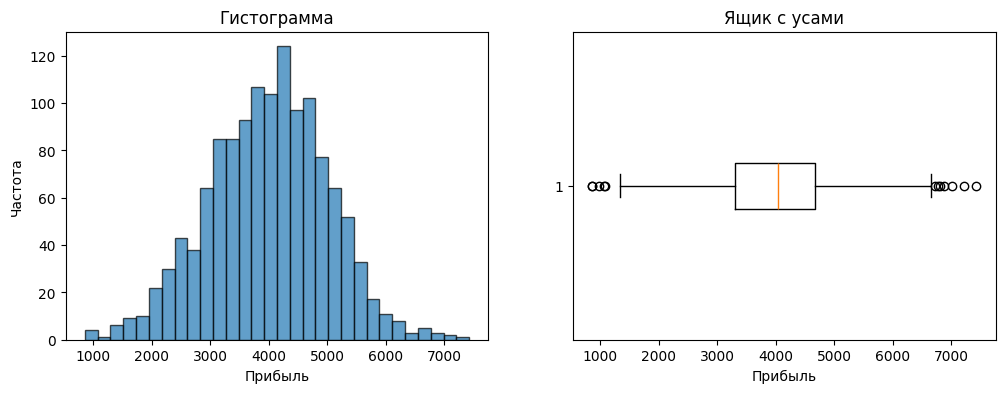

In [38]:
eda_reseach_int(money, money.columns)

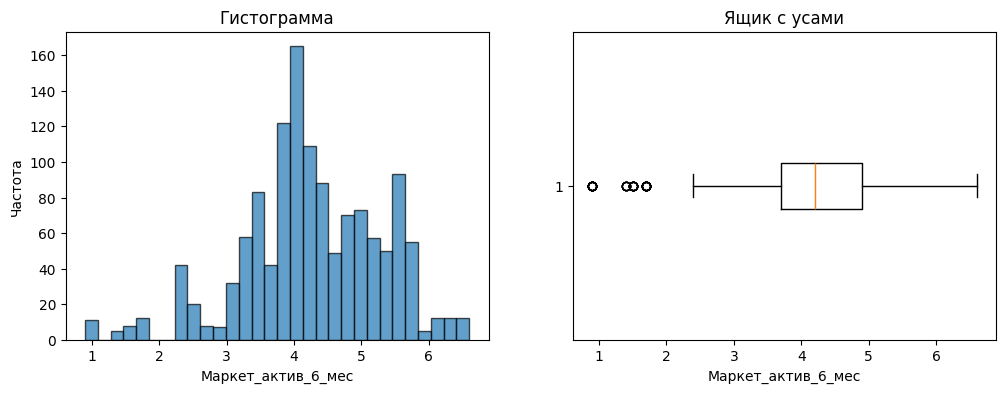

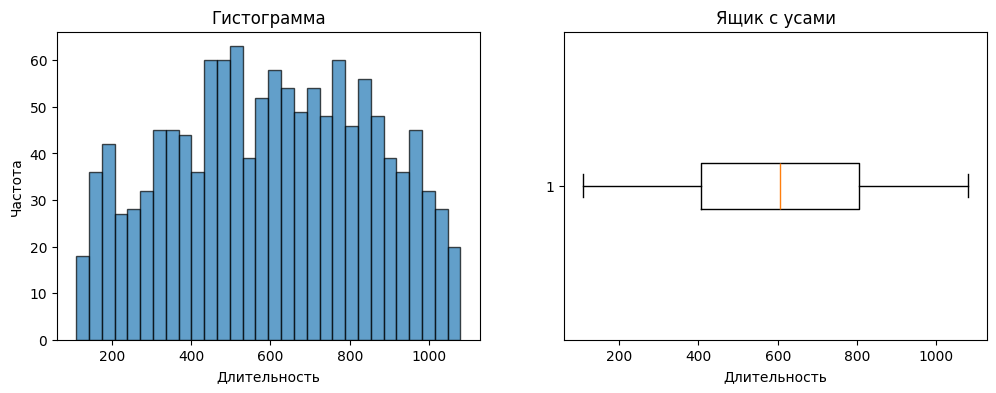

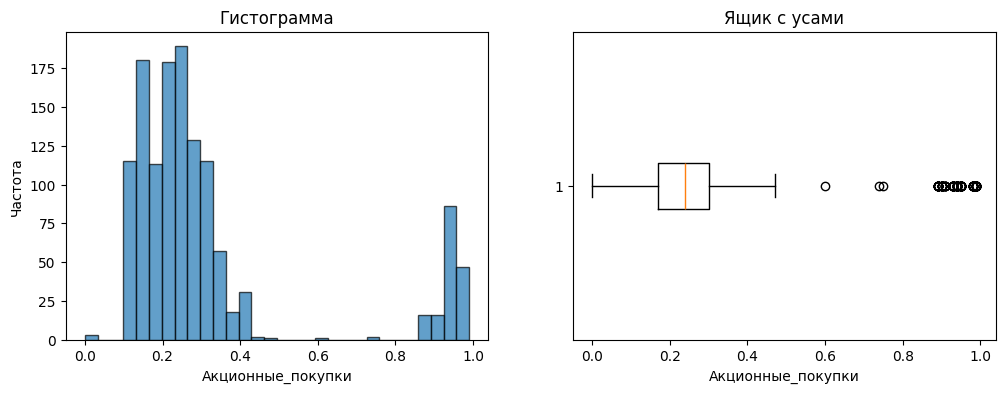

In [39]:
interval_columns = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки']

eda_reseach_int(market_file, interval_columns)

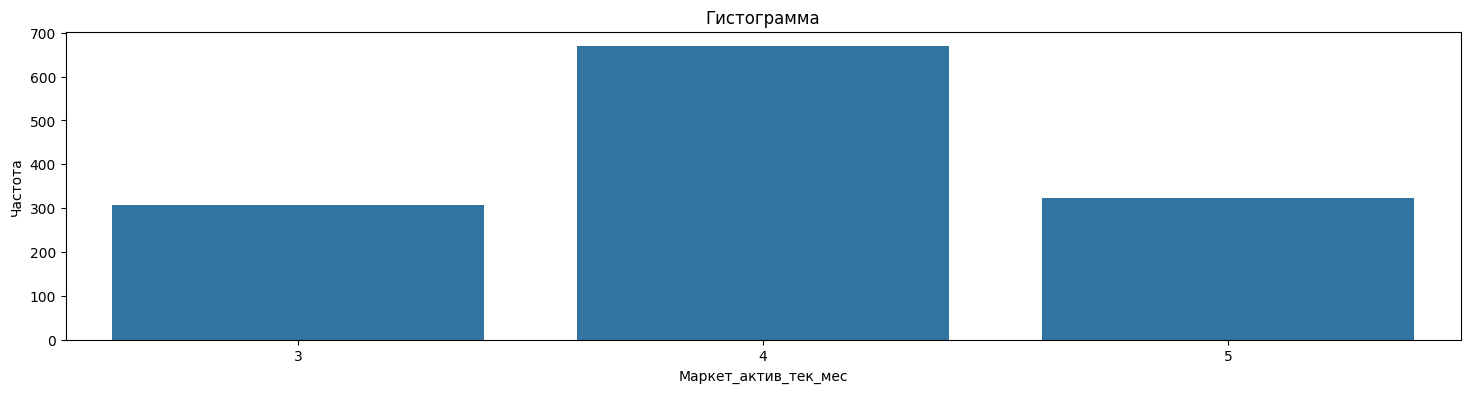

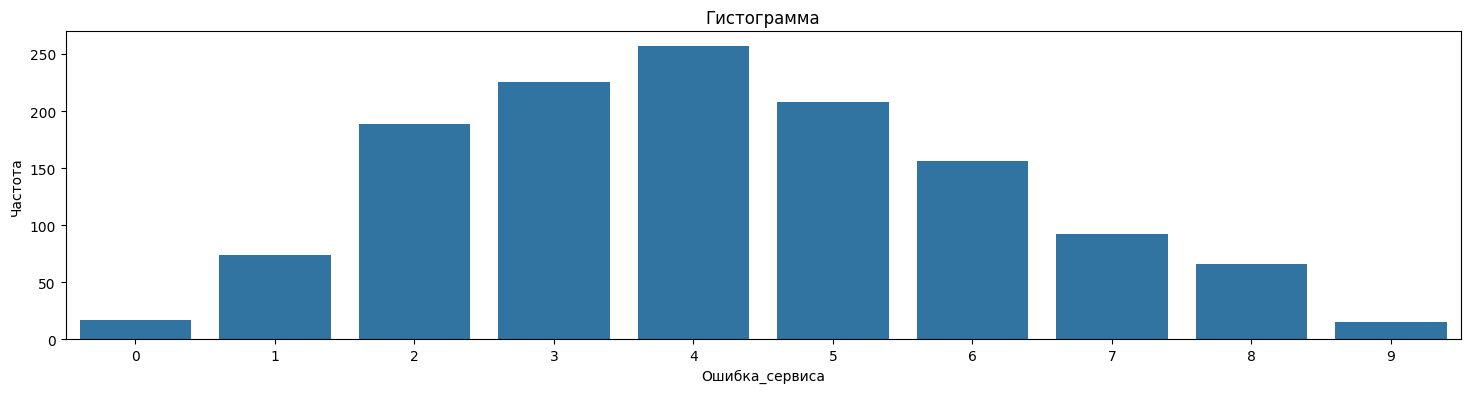

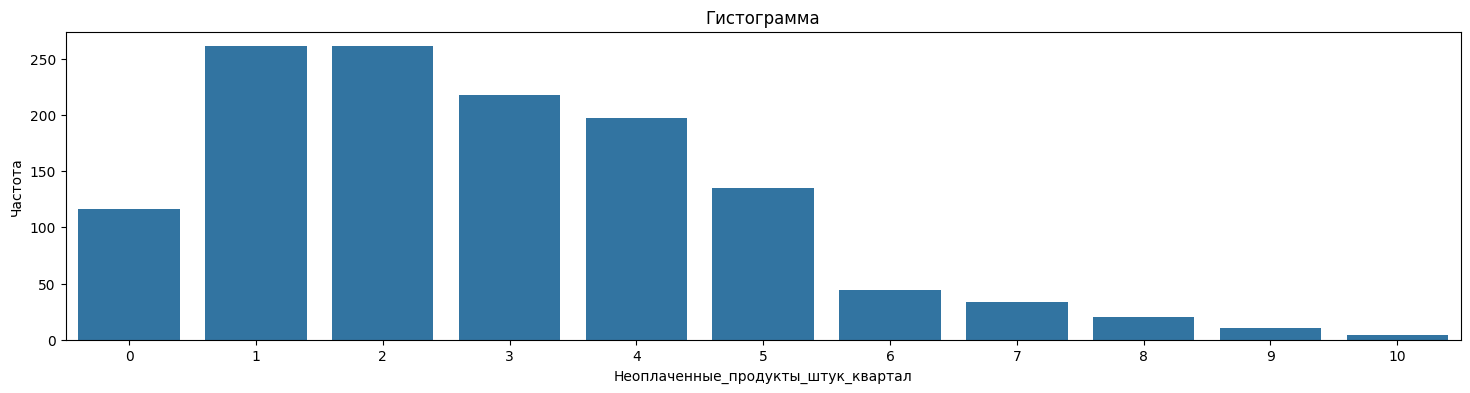

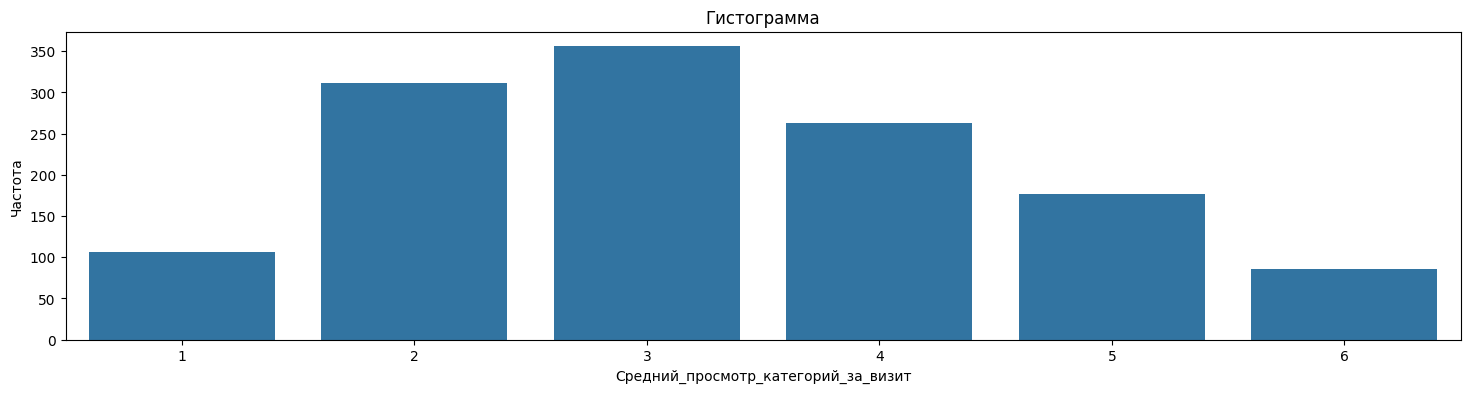

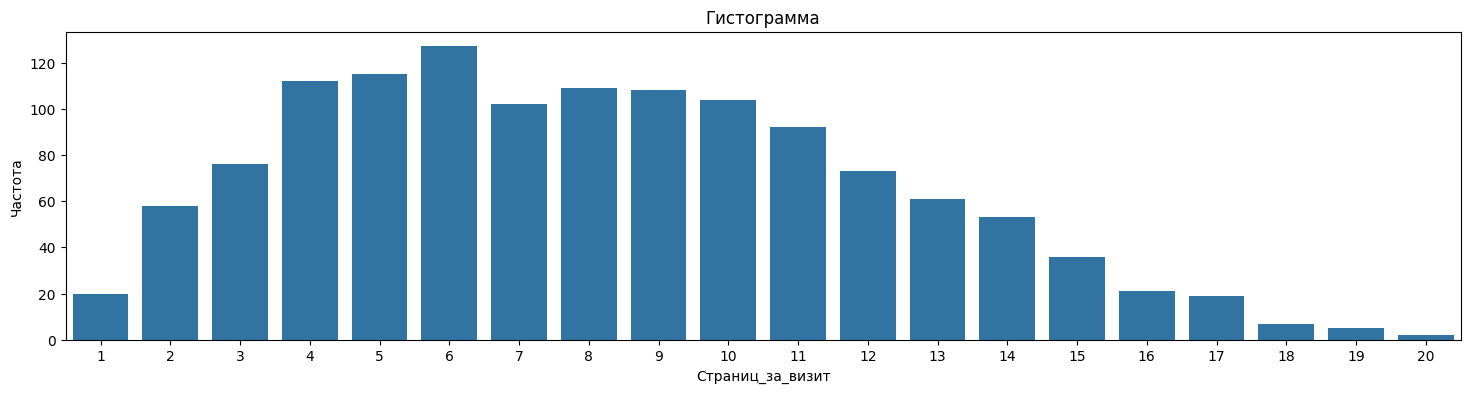

In [40]:
discrete_columns = ['Маркет_актив_тек_мес', 'Ошибка_сервиса', 
                    'Неоплаченные_продукты_штук_квартал',
                    'Средний_просмотр_категорий_за_визит',
                    'Страниц_за_визит']

eda_research_discrete(market_file, discrete_columns)

среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

Маркет_актив_6_мес:

- Распределение маркетинговой активности компании за 6 месяцев имеет форму, близкую к нормальному распределению.
- Большинство маркетинговых коммуникаций компании демонстрируют активность в диапазоне 4 единицы (звонки, рассылки, показы рекламы и прочие активности) на клиента. 

Маркет_актив_тек_мес:

- Активность в текущем месяце сосредоточена в трех точках: [3, 4, 5]
- Как и на предыдущем графике, наибольшая активность сосредоточена на 4. 


Длительность:

- Количество дней с момента регистрации покупателя распределена относительно равномерно, однако наблюдается некоторое уменьшение числа регистраций у покупателей с показателеми больше 1000 единиц.
- Пик активности Длительности приходится на диапазон около 500 единиц, а также, что все клиенты покупали какие-то товары, свидетельствует о наличии значительного числа постоянных клиентов.

Акционные_покупки:

- Активность сосредоточена в основном в двух плоскостях: от 0 до 0.4 и от 0.85 до 1.
- Большинство клиентов совершает акционные покупки с частотой менее 0.4. То есть доля акционных товаров, которые совершили покупатели менее 40%
- Небольшая часть клиентов покупает только акционные товары, их доля около 0.85%.

Средний_расход_категорий_за_визит:
показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

- Можно выделить три вершины с 2-4 категорий. В основном покупатели смотрят от 2 до 4 категорий в месяц,
- Возможно, клиенты преимущественно выбирают ограниченное количество категорий товаров во время покупок.

Неоплаченные_продукты_штук_квартал:
общее число неоплаченных товаров в корзине за последние 3 месяца.

- Большинство клиентов имеют от 0 до 3 неоплаченных товаров в корзине за квартал.
- Небольшая доля клиентов имеет от 4 до 6 неоплаченных товаров.
- Клиенты с более чем 7 неоплаченными товарами встречаются крайне редко.
- Гистограмма показывает явный спад частоты с увеличением количества неоплаченных товаров. Это говорит о том, что большинство клиентов либо полностью оплачивают свои корзины, либо оставляют лишь небольшое количество товаров неоплаченными.
- Практически отсутствуют клиенты с количеством неоплаченных товаров выше 10 за квартал, что может свидетельствовать об их внимательности или эффективных действиях компании по напоминанию об оплате.

Ошибка_сервиса:
число сбоев, которые коснулись покупателя во время посещения сайта.

- Ошибки сервиса чаще всего встречаются с частотой около 4-6 единиц.
- Существуют группы клиентов, где ошибки достигают 10 и более единиц, что может указывать на необходимость улучшения качества обслуживания.

Страницы_за_визит:
среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- Число посещённых страниц за визит имеет равномерное распределение, пик активности приходится на диапазон 8-12 страниц.
- Высокая посещаемость страниц (>15) может говорить об активных покупателях, либо о клиентах, ищущих нужные товары.


Общие выводы:

- Данные показывают, что значительная часть клиентов активно взаимодействует с маркетом, особенно в текущем месяце.
- Уровень покупательской активности стабилен для большинства клиентов, что говорит о хорошей удерживаемости.
- Следует обратить внимание на пики активности, чтобы понять, какие факторы стимулируют клиентов в этот период.
- Большинство клиентов совершает покупки в стандартных категориях, что может указывать на повторяющиеся паттерны покупок.
- Обнаружены частые ошибки сервиса и несоответствия товаров, которые требуют внимания и могут быть связаны с логистикой или системой учёта.
- Акционные предложения привлекают небольшую группу клиентов, возможно, стоит пересмотреть их формат или целевую аудиторию.
- Количество посещаемых страниц говорит о том, что клиенты тратят достаточно времени на выбор товаров, что может быть как положительным (больше продаж), так и отрицательным (сложность навигации).








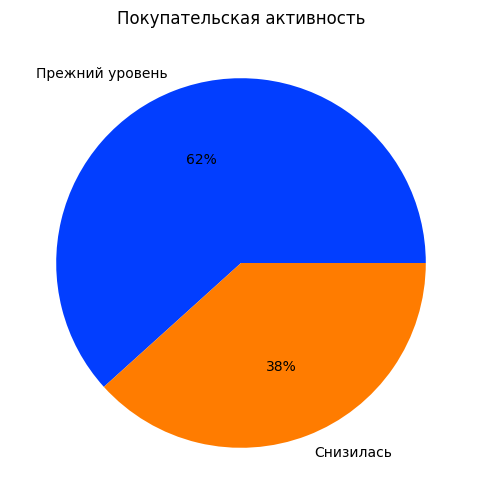

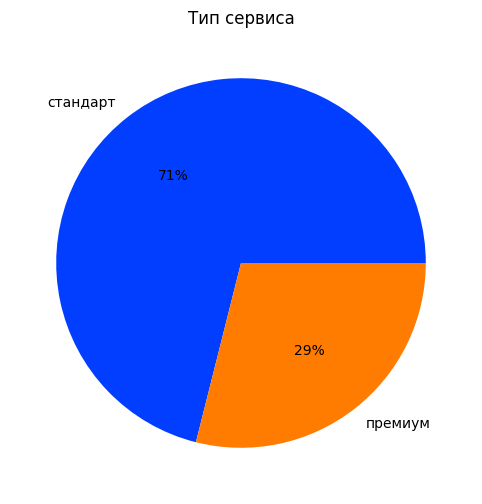

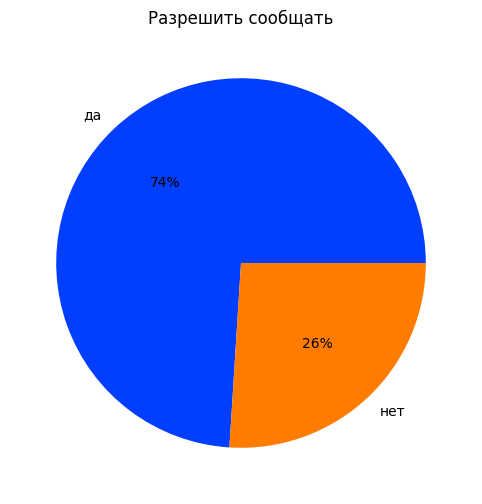

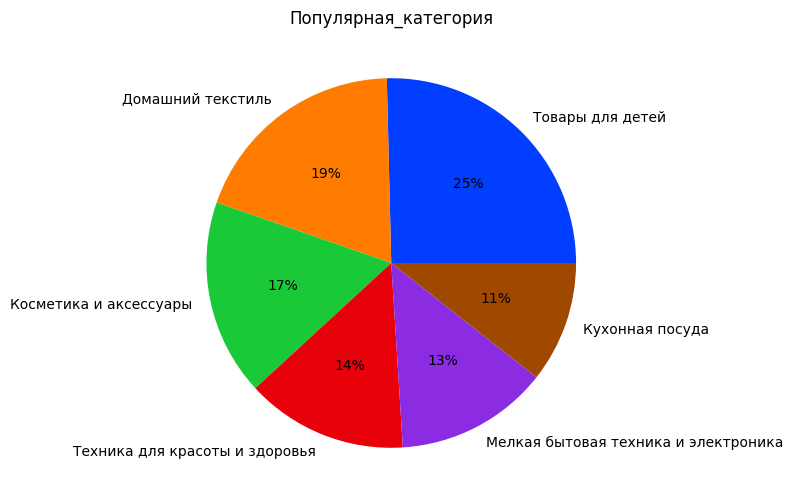

In [41]:
eda_reseach_obj(market_file)

Наблюдается дисбаланс данных в целевой переменной. Поэтому в случае дисбаланса классов метрика ROC-AUC – хороший выбор.


**Почему ROC-AUC?** 

    1️⃣ Учитывает ранжирование вероятностей

- ROC-AUC измеряет, насколько хорошо модель различает положительный и отрицательный классы. Даже если классы несбалансированы (62% на 38%), метрика останется информативной. - 
    <br>
  2️⃣ Не зависит от порога вероятностей
  

- Метрики, такие как Accuracy, могут давать завышенные оценки при дисбалансе, если модель просто предсказывает более частый класс.
- ROC-AUC строит кривую на всех возможных порогах => оценивает качество модели в целом.


3️⃣ Чувствительность к дисбалансу

- В отличие от Precision и Recall, ROC-AUC всё ещё работает при умеренном дисбалансе (примерно до 80/20).
При сильном дисбалансе (>90/10) лучше использовать PR-AUC, так как Precision становится важнее.


❌ Почему не Accuracy?
Если модель просто предскажет чаще встречающийся класс (62%), Accuracy будет ≈ 62%, даже если модель ничего не умеет.
Это не даёт реальной оценки качества.

Покупательская активность:

- Большинство клиентов сохранили прежний уровень покупательской активности, что свидетельствует о стабильности клиентской базы.
- Доля клиентов, чья активность снизилась, значительно меньше, что может быть положительным показателем, но требует внимания, чтобы предотвратить дальнейший отток.

Тип сервиса:

- Большая часть клиентов использует стандартный сервис, тогда как пользователей премиум-сервиса существенно меньше.
- Возможно, стоит пересмотреть преимущества премиум-сервиса или предложить его дополнительной группе клиентов, чтобы повысить интерес.

Разрешить сообщать:

- Значительная часть клиентов дала согласие на получение маркетинговых сообщений ("да").
- Однако заметна доля клиентов, которые отказались от сообщений ("нет"). Это может указывать на необходимость более гибкого подхода в коммуникациях, например, уточнение предпочтений или выбор формата взаимодействия.

Популярная категория:

- Наиболее популярная категория — товары для детей, что может отражать ключевую целевую аудиторию.
- Другие популярные категории включают домашний текстиль, косметика и аксессуары, а также товары для здоровья и товаров.
- Категории, такие как крупная бытовая техника, менее популярны, что может говорить о специфике спроса или необходимости дополнительных маркетинговых акций в этих направлениях.

In [42]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [43]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


## 4. Объединение таблиц

In [44]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [45]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [46]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [47]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [48]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [49]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [50]:
# Поворот таблицы с выручкой
market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка').reset_index()
market_money_pivot.columns = ['id', 'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']

# Поворот таблицы market_time
market_time_pivot = market_time.pivot(index='id', columns='Период', values='минут').reset_index()
market_time_pivot.columns = ['id', 'Время_текущий_месяц', 'Время_предыдущий_месяц']

# Объединение таблиц
merged_df = market_file.merge(market_money_pivot, on='id', how='left')
df = merged_df.merge(market_time_pivot, on='id', how='left')


In [51]:
# Просмотр итоговой таблицы
df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,Время_текущий_месяц,Время_предыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


Итоговая таблица содержит данные из market_file, market_time, market_mone. В итоговой таблице выделены отдельно столбцы для каждого периода.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [53]:
market_file.shape[0]

1300

In [54]:
market_file.shape[1]

13

In [55]:
df.shape[0]

1300

In [56]:
df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_препредыдущий_месяц            0
Выручка_предыдущий_месяц               0
Выручка_текущий_месяц                  0
Время_текущий_месяц                    0
Время_предыдущий_месяц                 0
dtype: int64

In [57]:
df.duplicated().sum()

np.int64(0)

Данные после слияния в порядке

## 5. Корреляционный анализ

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [59]:
df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц,Время_текущий_месяц,Время_предыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


Категориальных данных в виде числовых переменных не обнаружено, поэтому в numeric_columns передадим все числовые столбцы

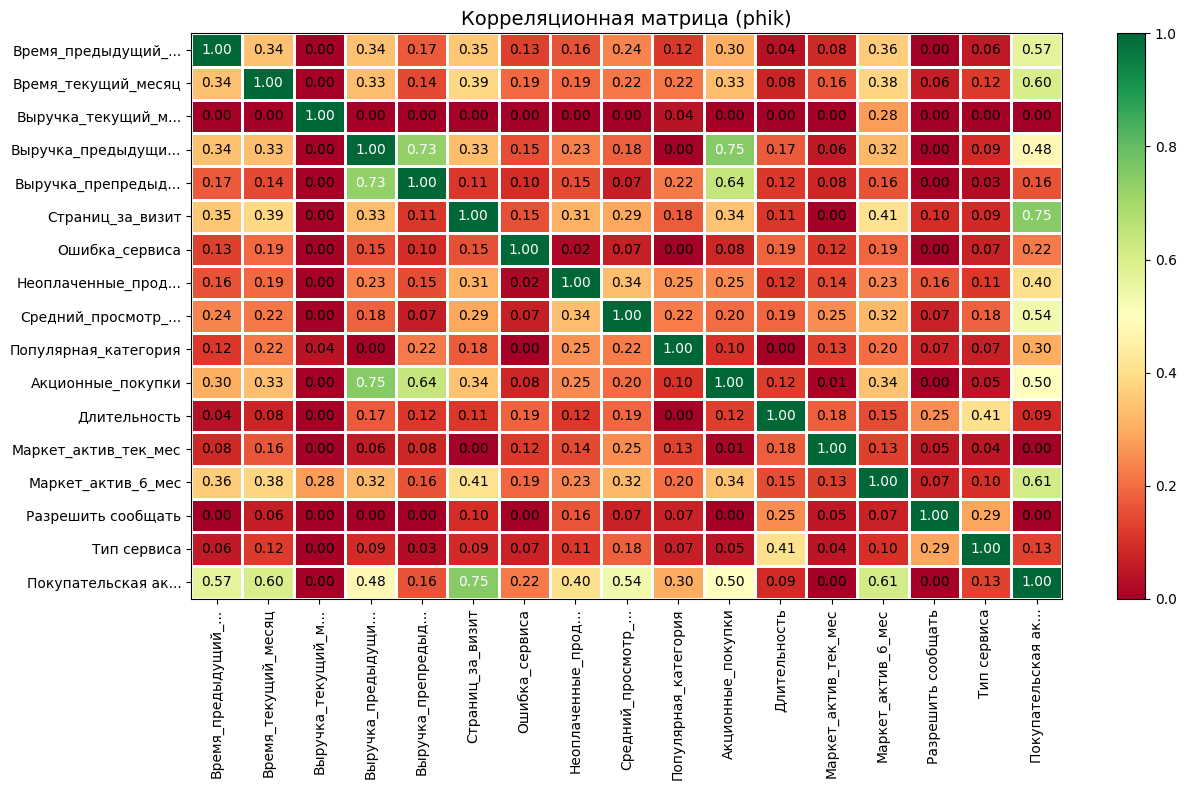

In [60]:
data = df.drop(['id'], axis=1)


interval_columns = ['Длительность', 'Акционные_покупки', 'Выручка_препредыдущий_месяц',
                    'Выручка_предыдущий_месяц','Выручка_текущий_месяц']
# Вычисляем корреляционную матрицу с использованием phik
phik_corr = data.phik_matrix(interval_cols=interval_columns)
# Визуализация корреляционной матрицы
plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    figsize=(13, 8),
    vmin=0,
    vmax=1,
    title="Корреляционная матрица (phik)"
)

Вспомним, что целевым признаком является покупательская активность.
Мультиколлинеарность не обнаружена, есть хорошо коррелирующие между собой признаки, нам это на руку. Есть достаточно признаков, которые слабо коррелируют с целевым признаком.

## 6. Использование пайплайнов


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Выделим целевой признак и обучающие.

In [62]:
y = df['Покупательская активность']
X = df.drop(['Покупательская активность'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
)
X_train_id = X_train
X_test_id = X_test

X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'], axis=1)


In [63]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1040, 16)
(1040,)
(260, 16)
(260,)


Пора использовать пайплайны для обучения моделей. Закодируем категориальные признаки:


In [64]:
label_encoder = LabelEncoder()

In [65]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [66]:

ohe_columns = ['Разрешить сообщать', 'Популярная_категория']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_препредыдущий_месяц','Выручка_предыдущий_месяц','Выручка_текущий_месяц' ,'Время_текущий_месяц','Время_предыдущий_месяц']


In [67]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [68]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [69]:
data_preprocessor = ColumnTransformer(
    transformers= [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [70]:


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [71]:
param_grid = [
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            max_iter=1000 
        )],
        'models__C': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # Support Vector Classifier (SVM)
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [72]:

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Разрешить '
                                                                                'сообщать',
                                                                                'Популя...
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': [0.01, 0.1, 1, 10],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0.1, 1, 10],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [73]:


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                       

In [74]:
cv_results = pd.DataFrame(randomized_search.cv_results_)

# Сортировка по метрике (например, ROC-AUC)
cv_results_sorted = cv_results.sort_values(by='mean_test_score', ascending=False)
cv_results_sorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__kernel,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.173877,0.014470,0.015534,0.002804,StandardScaler(),rbf,10.0,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.896289,0.928125,0.915039,0.911785,0.894417,0.909131,0.012523,1
3,0.019014,0.003360,0.007879,0.001701,StandardScaler(),NaN,10.0,"LogisticRegression(max_iter=1000, penalty='l1'...",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.915723,0.927734,0.873828,0.899912,0.890590,0.901557,0.018856,2
0,0.183008,0.012683,0.025235,0.014618,StandardScaler(),linear,1.0,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.908887,0.924707,0.872949,0.903837,0.885683,0.899213,0.018098,3
1,58.577794,8.515748,0.029296,0.012977,passthrough,linear,10.0,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.909082,0.919629,0.864160,0.885487,0.879305,0.891533,0.020163,4
9,0.014894,0.004383,0.020983,0.019958,StandardScaler(),NaN,NaN,KNeighborsClassifier(),NaN,NaN,3.0,"{'preprocessor__num': StandardScaler(), 'model...",0.876416,0.882812,0.886621,0.919586,0.871701,0.887427,0.016880,5


In [75]:
# # Пример вывода только интересующих столбцов
# cv_results_sorted[['param_models']].head()  # .head() для того чтобы вывести только первые 5 строк
# # Увеличиваем количество отображаемых строк и столбцов
# pd.set_option('display.max_rows', None)  # Отображать все строки
# pd.set_option('display.max_columns', None)  # Отображать все столбцы
# print(cv_results_sorted)  # Печатаем все строки и столбцы


In [76]:

pd.reset_option('display.max_columns')  # Вернуть к значению по умолчанию
pd.reset_option('display.max_rows')  # Вернуть к значению по умолчанию

In [77]:
y_predict = randomized_search.predict(X_test)
y_predict_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_predict_proba[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.896625


## 7. Анализ важности признаков

In [78]:
shap.initjs()

In [88]:
# Ручная предобработка, так как с пайплайном не получается
# 1. Преобразуем категориальные признаки с помощью OneHotEncoder и OrdinalEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ord_enc = OrdinalEncoder(categories=[['стандарт', 'премиум']],
                         handle_unknown='use_encoded_value',
                         unknown_value=-1)

# 2. Преобразуем числовые признаки с помощью MinMaxScaler
scaler = MinMaxScaler()

# Преобразуем категориальные, порядковые и числовые признаки для обучающих данных
X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
X_train_ord = ord_enc.fit_transform(X_train[ord_columns])
X_train_num = scaler.fit_transform(X_train[num_columns])

# Применяем обработку к тестовым данным (используем transform, чтобы не обучать заново)
X_test_ohe = ohe.transform(X_test[ohe_columns])  # Обратите внимание на transform, а не fit_transform
X_test_ord = ord_enc.transform(X_test[ord_columns])  # Используем transform
X_test_num = scaler.transform(X_test[num_columns])  # Используем transform

# Объединяем все признаки
X_train_processed = pd.concat([
    pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(ohe_columns)),
    pd.DataFrame(X_train_ord, columns=ord_columns),
    pd.DataFrame(X_train_num, columns=num_columns)
], axis=1)

X_test_processed = pd.concat([
    pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(ohe_columns)),
    pd.DataFrame(X_test_ord, columns=ord_columns),
    pd.DataFrame(X_test_num, columns=num_columns)
], axis=1)

# Обучаем модель
#model = LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')
model = SVC(C=10, probability=True, random_state=42)
model.fit(X_train_processed, y_train)


SVC(C=10, probability=True, random_state=42)

In [89]:
# Получаем предсказания
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

# Вычисляем ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc}")

ROC AUC score: 0.9045000000000001


In [92]:

# Получаем предсказания вероятности
explainer = shap.KernelExplainer(model.predict_proba, X_train_processed[:100])  # срез X_train_processed[:100] для ускорения вычислений. 
shap_values = explainer(X_test_processed)



  0%|          | 0/260 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

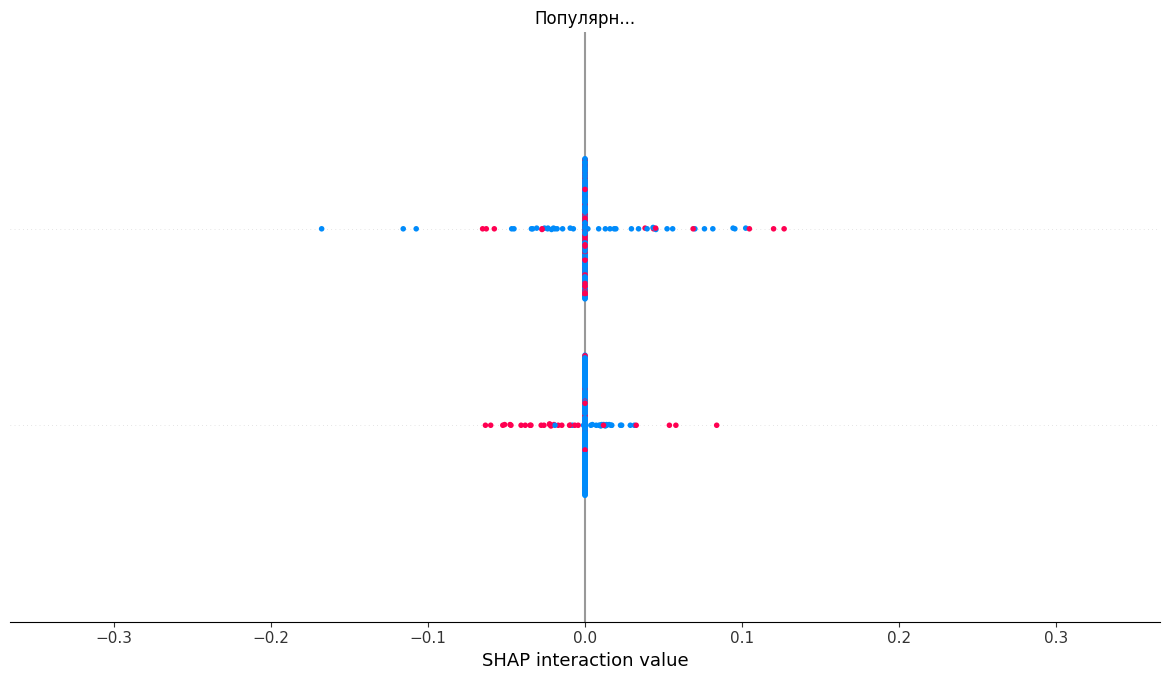

In [93]:
# Визуализируем SHAP значения
shap.summary_plot(shap_values, X_test_processed)

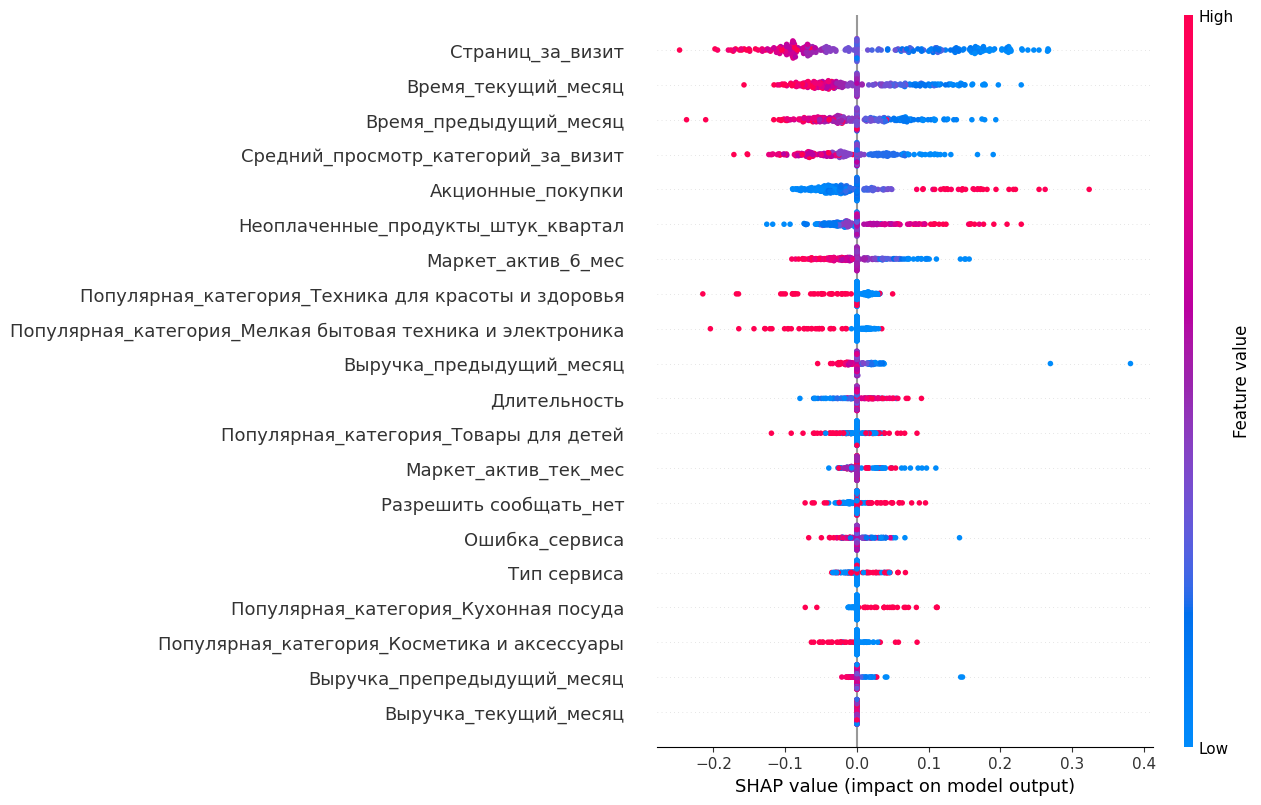

In [94]:
# Построение графика beeswarm
shap.plots.beeswarm(shap_values[:,:,1], max_display = 21) 


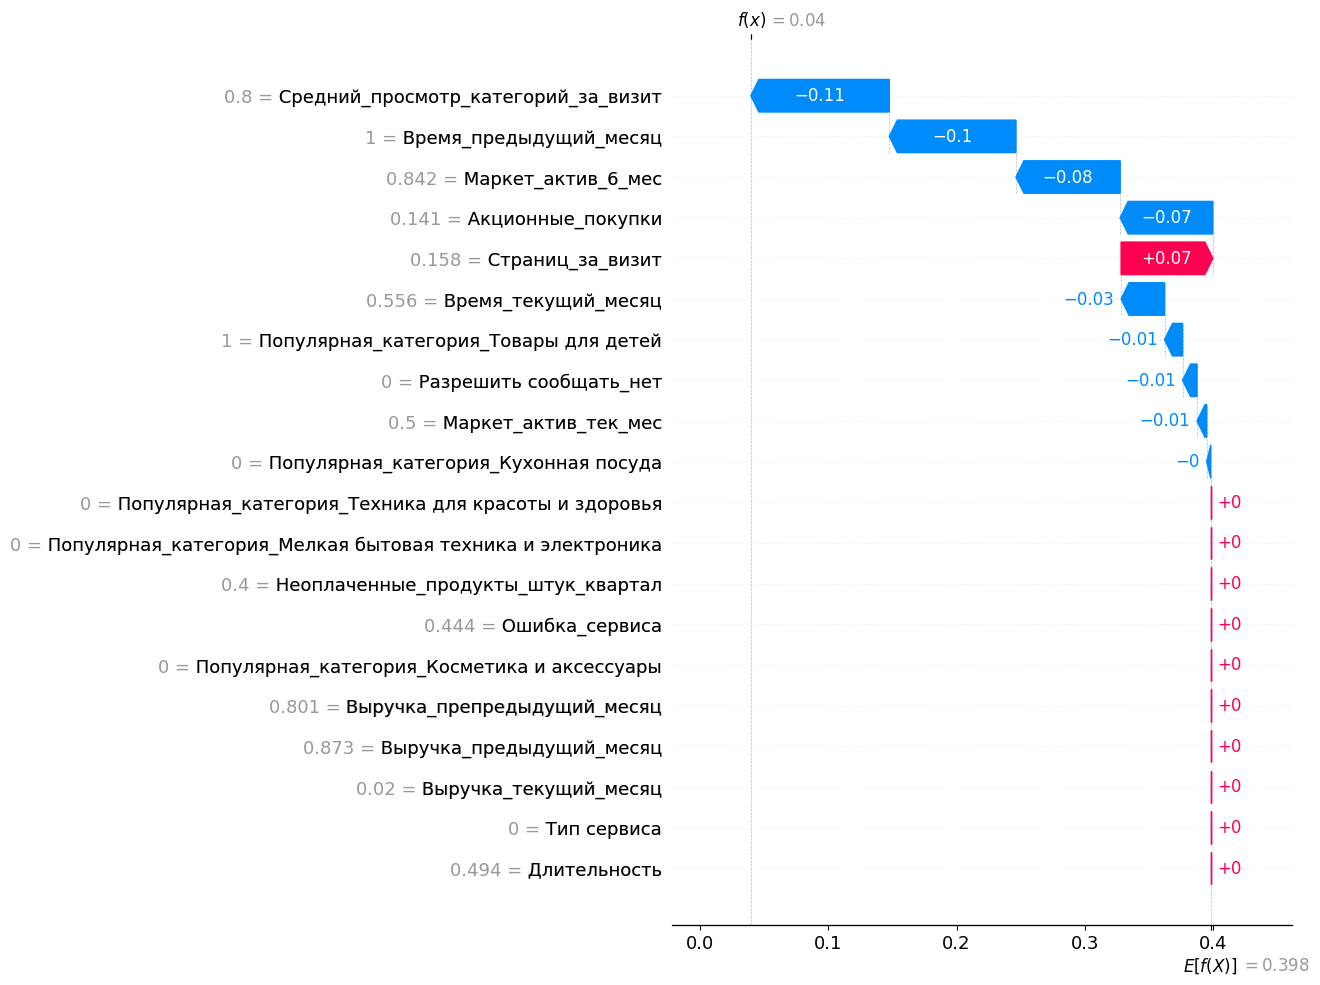

In [95]:
shap.plots.waterfall(shap_values[1,:,1], max_display = 21)


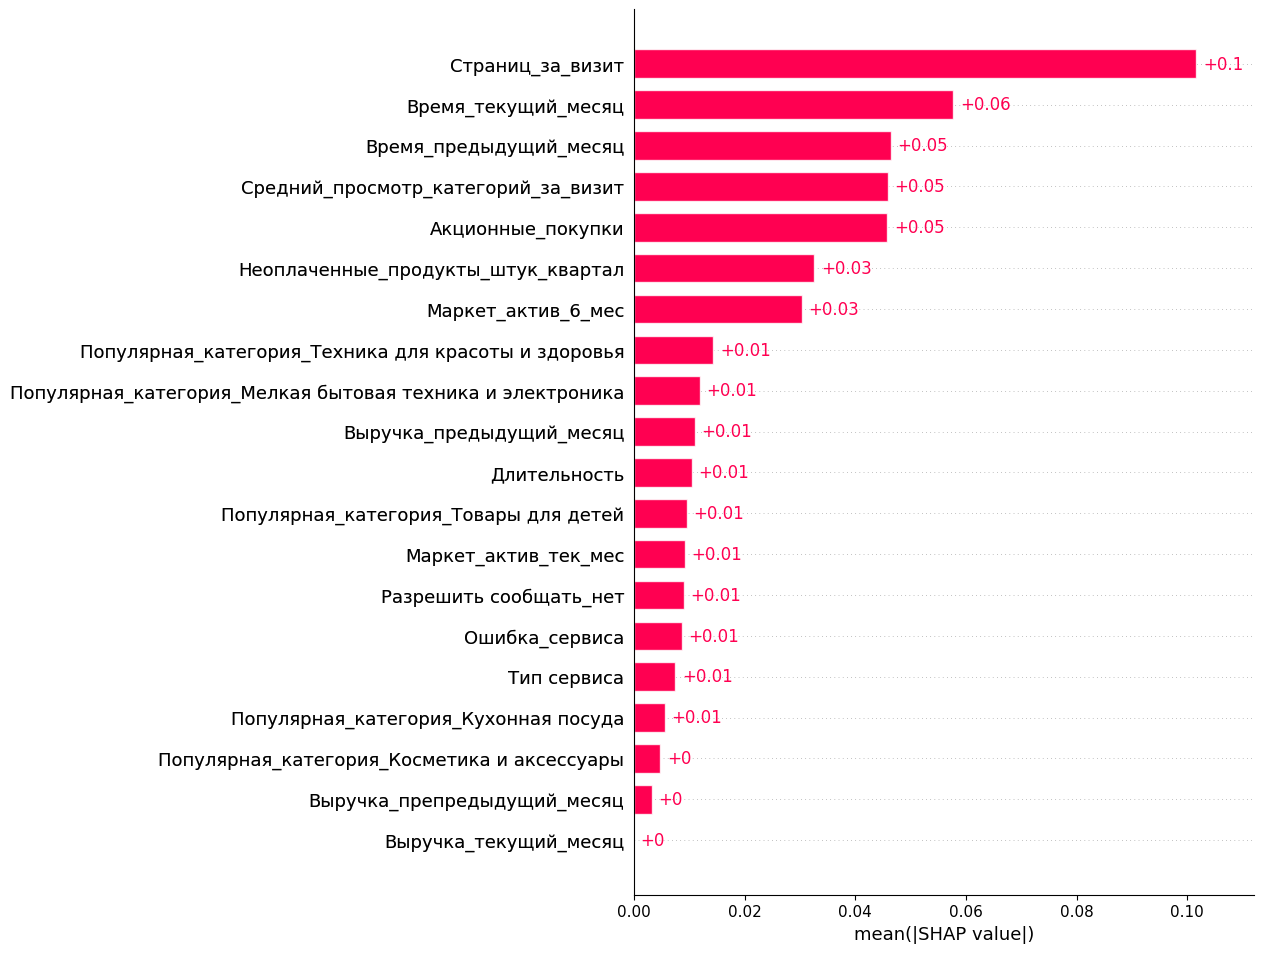

In [96]:
shap.plots.bar(shap_values[:,:,1], max_display = 21)


### Выводы:


Наиболее значимые признаки:

    - Время_текущий_месяц
    - Страниц_за_визит
    - Средний просмотр категорий за визит
    - Акционные покупки
    
Малозначимые признаки:

    - Популярные категории
    - Разрешить сообщать_нет
    - Длительность
    
Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:

    - Время_текущий_месяц – наиболее значимый признак. Компании стоит проанализировать поведение покупателя и персонализировать для них предложения, чтобы удержать на сайте
    - Страниц_за_визит очень важный признак. Чем больше страниц посещает покупатель, тем большая вероятность что покупательская активность не снизится
    - Средний просмотр категорий за визит может свидетельствовать о том, насколько эффективно пользователю удается ориентироваться по категориям товаров и продуктов на сайте. Руководству стоит обратить внимание на улучшение структуры категорий и интерфейса сайта, чтобы покупатели могли легко находить интересующие их товары.
    - Покупки, совершенные в период акций, являются важным индикатором покупательской активности. Это может показать, что клиент заинтересован в скидках и выгодных предложениях. Стратегия бизнеса должна включать активное использование акций для стимулирования продаж и увеличения лояльности клиентов.
    

## 8. Сегментация покупателей

Рассмотрим таких клиентов у которых высока вероятность, что их покупательская активность снизится, но при этом прибыль, которую они приносят, выше средней. Был выбран этот сегмент, так как они приносят высокую прибыль и могут уйти

In [97]:


pred = randomized_search.predict_proba(X_test_id)[:, 1]
X_test_id['predicted'] = pred

#X_test.reset_index(inplace=True)
segment = X_test_id.merge(money, on='id')

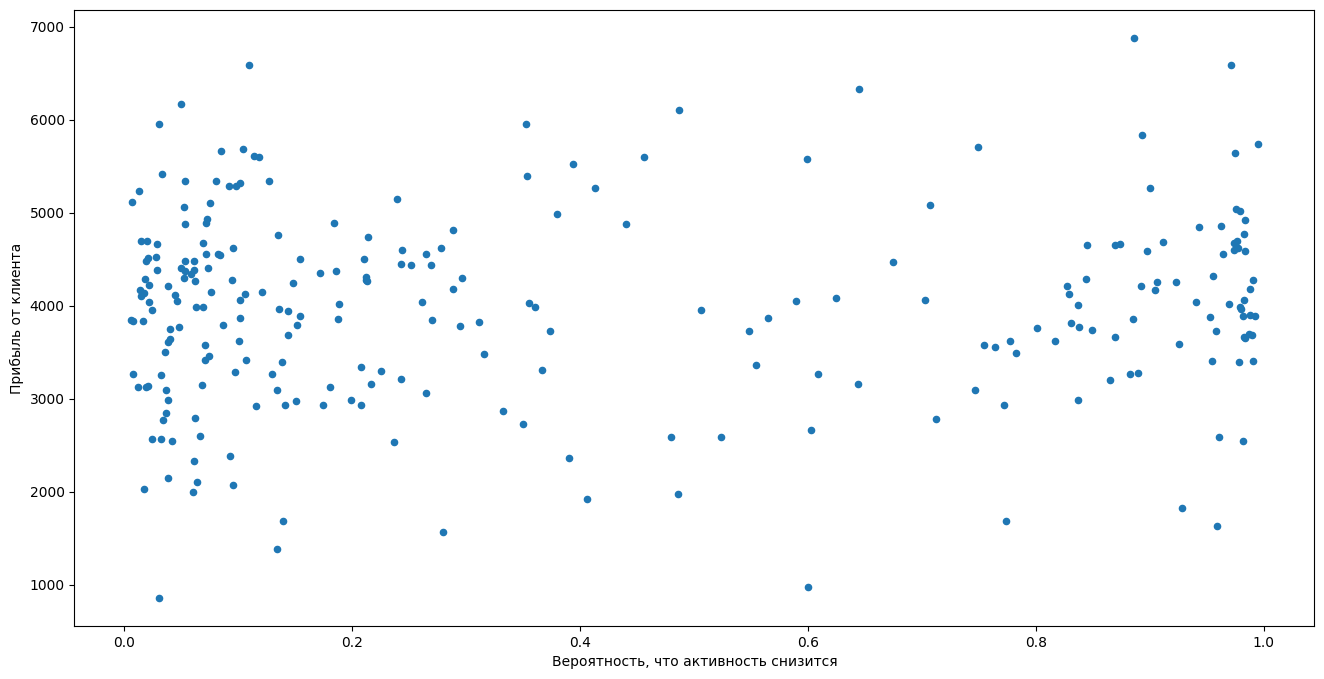

In [98]:
segment.plot.scatter(x = 'predicted', y = 'Прибыль', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

Все клиенты и вероятность что прибыль снизится

Теперь рассмотрим клиентов, которые приносят прибыль выше средней:

In [99]:
segment = segment[(segment['predicted'] >= 0.65) & (segment['Прибыль'] >= segment['Прибыль'].mean())]

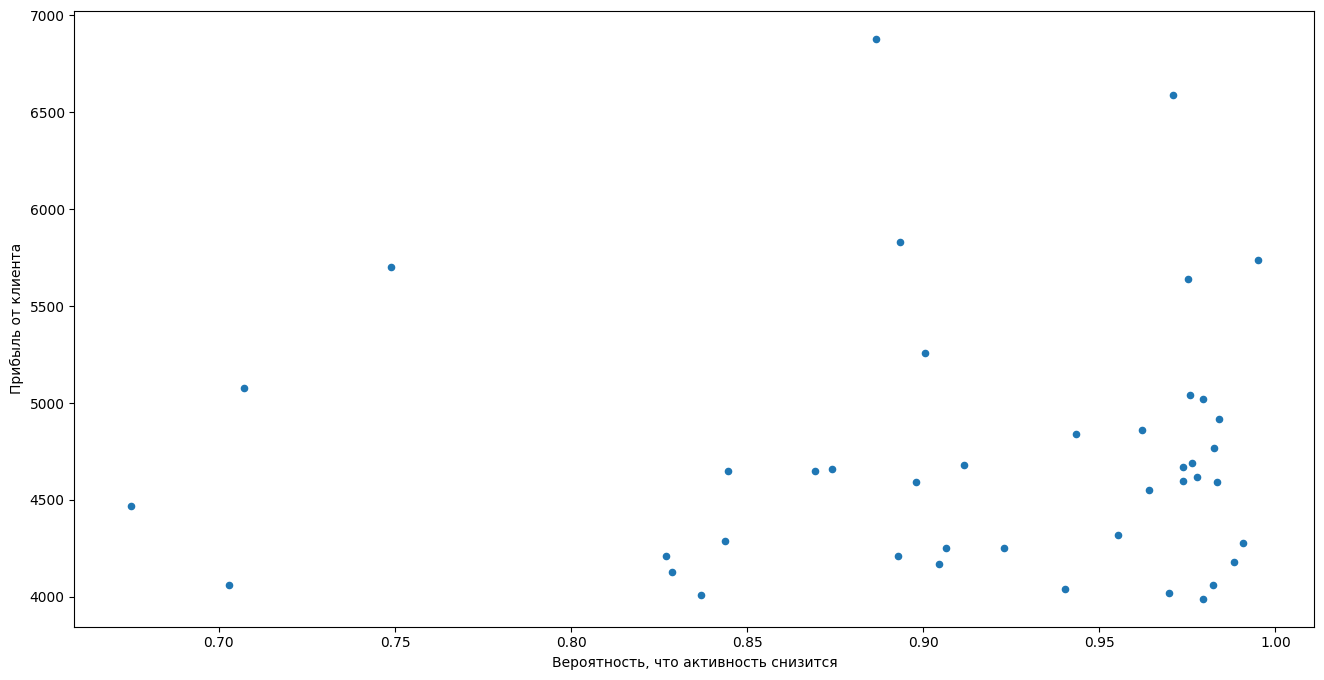

In [100]:
segment.plot.scatter(x = 'predicted', y = 'Прибыль', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

Их-то и нужно удержать. Посмотрим


In [101]:
segment.shape

(42, 19)

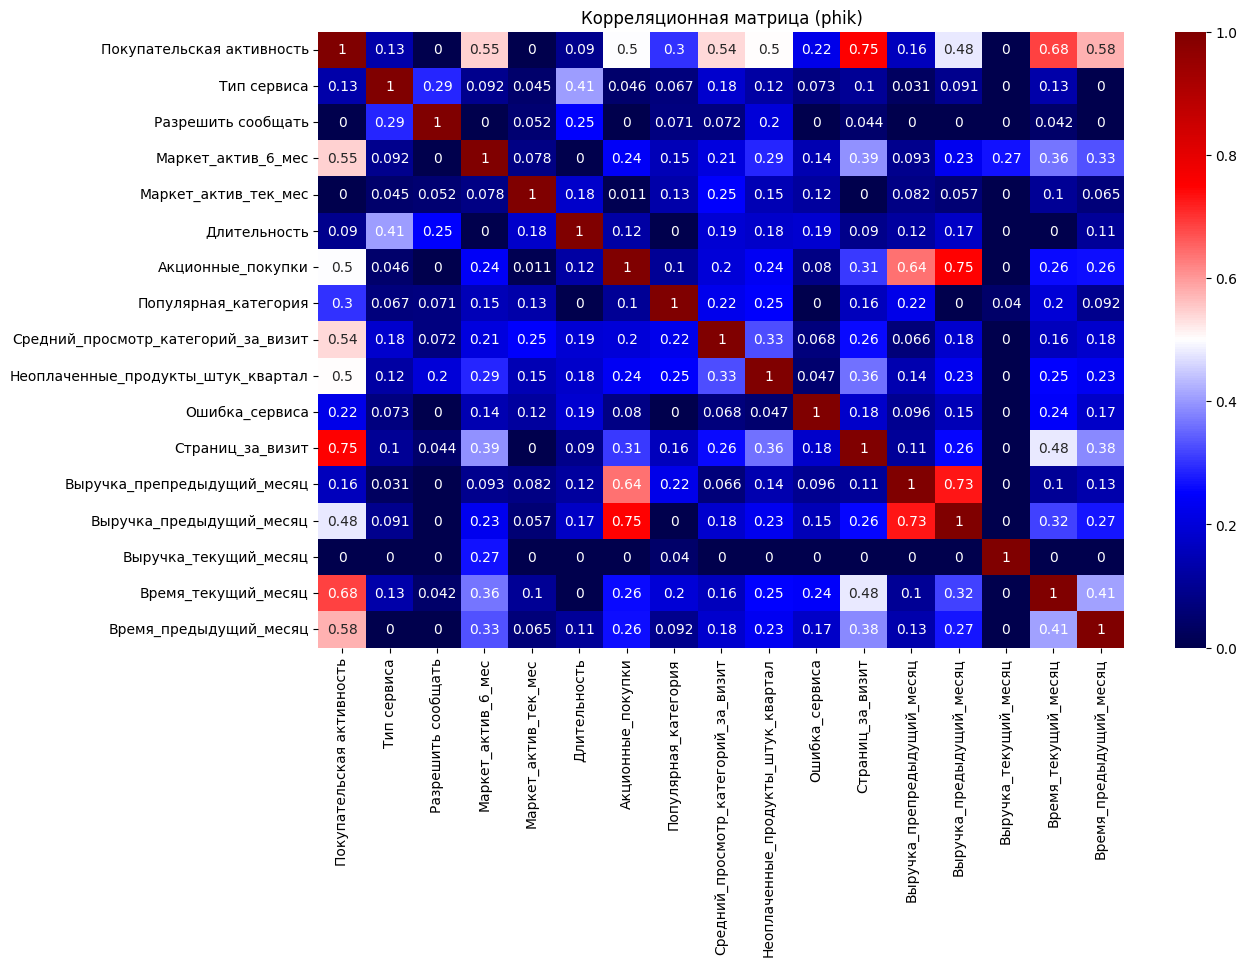

In [102]:
#segment = segment.drop(['id'], axis=1)


numeric_columns = segment.select_dtypes(include=['number']).columns.tolist()
# Вычисляем корреляционную матрицу с использованием phik
phik_corr = data.phik_matrix(interval_cols=numeric_columns)
# Визуализация корреляционной матрицы
plt.figure(figsize=(13, 8))
sns.heatmap(phik_corr, annot=True, cmap='seismic', vmin=0, vmax=1)
plt.title("Корреляционная матрица (phik)")
plt.show()


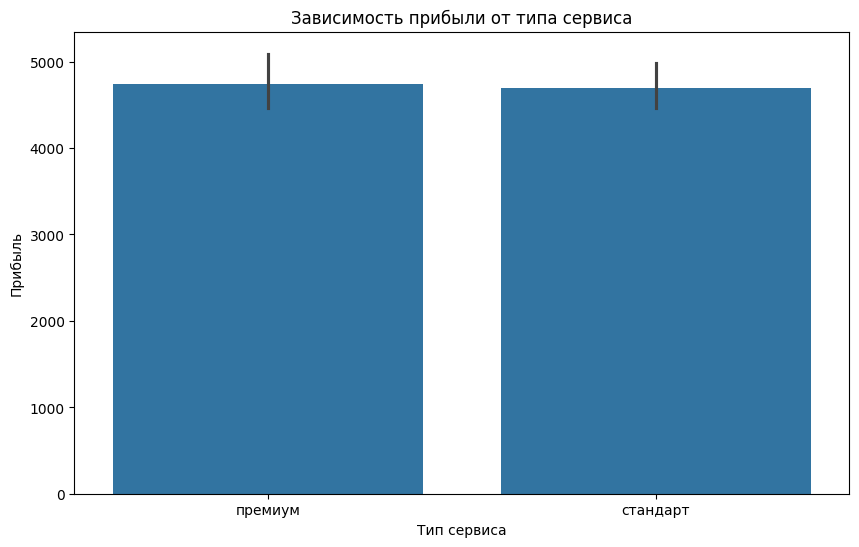

In [103]:
plt.figure(figsize=(10, 6))

# Построим boxplot для зависимости прибыли от типа сервиса
sns.barplot(x='Тип сервиса', y='Прибыль', data=segment)

# Добавим заголовок и метки осей
plt.title('Зависимость прибыли от типа сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Прибыль')

# Отобразим график
plt.show()

In [104]:
segment.groupby('Тип сервиса')["Прибыль"].count()

Тип сервиса
премиум     18
стандарт    24
Name: Прибыль, dtype: int64

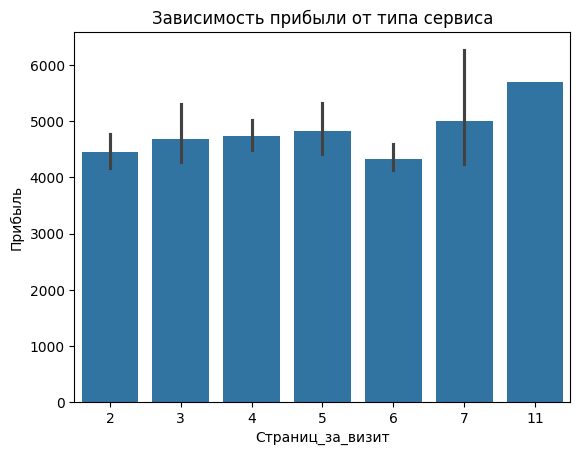

In [105]:
# Построим boxplot для зависимости прибыли от Страниц_за_визит
sns.barplot(x='Страниц_за_визит', y='Прибыль', data=segment)

# Добавим заголовок и метки осей
plt.title('Зависимость прибыли от типа сервиса')
plt.xlabel('Страниц_за_визит')
plt.ylabel('Прибыль')

# Отобразим график
plt.show()

Text(0, 0.5, 'Прибыль')

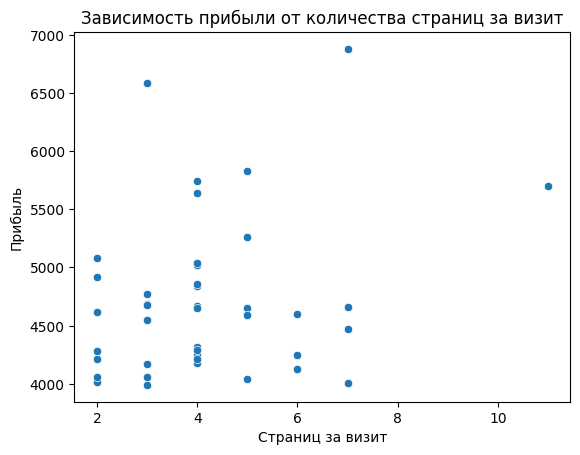

In [106]:
sns.scatterplot(x='Страниц_за_визит', y='Прибыль', data=segment)

# Добавим заголовок и метки осей
plt.title('Зависимость прибыли от количества страниц за визит')
plt.xlabel('Страниц за визит')
plt.ylabel('Прибыль')

# Отобразим графикplt.show()

In [107]:
segment.groupby('Страниц_за_визит')["Прибыль"].count()

Страниц_за_визит
2      7
3      8
4     13
5      6
6      3
7      4
11     1
Name: Прибыль, dtype: int64

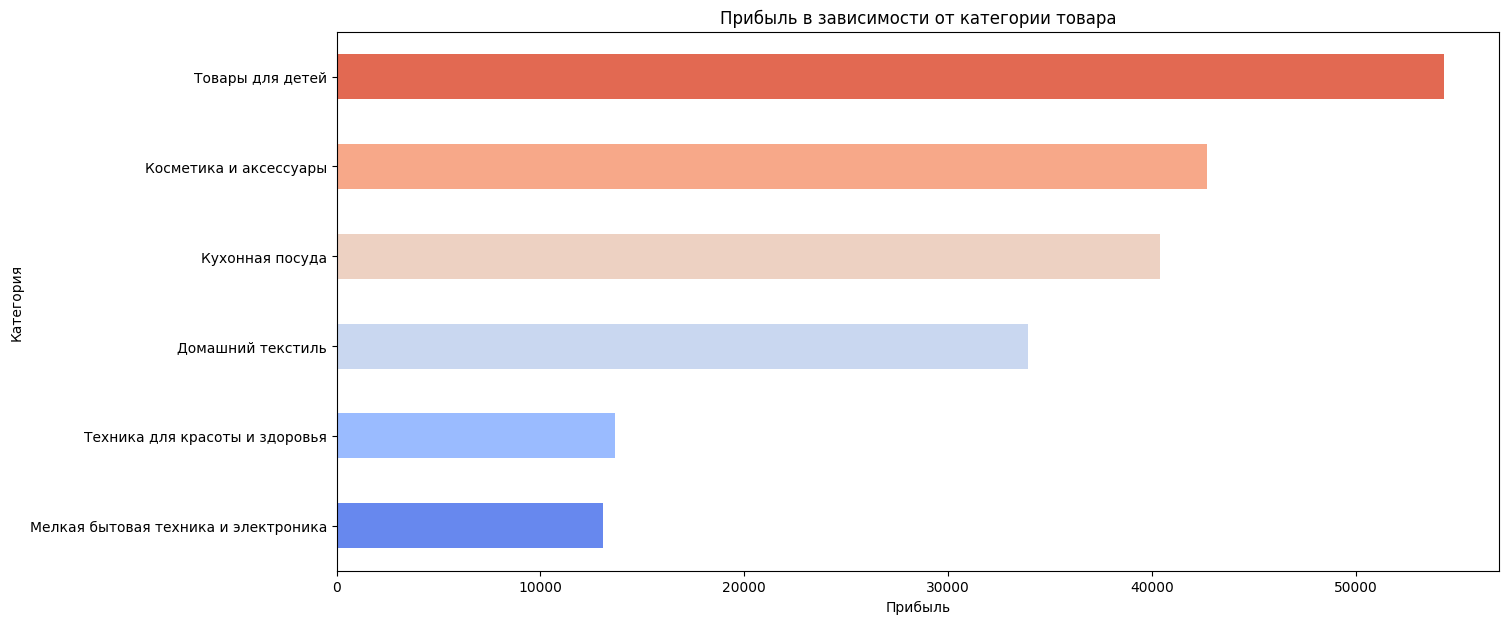

In [108]:
segment.groupby('Популярная_категория')['Прибыль'].sum().sort_values(ascending=True).plot(
    kind='barh',
    figsize=(15, 7), 
    color=sns.color_palette("coolwarm", len(segment['Популярная_категория'].unique()))  # Используем палитру цветов
)

plt.title('Прибыль в зависимости от категории товара')
plt.ylabel('Категория')
plt.xlabel('Прибыль')

plt.show()

Text(0, 0.5, 'Прибыль')

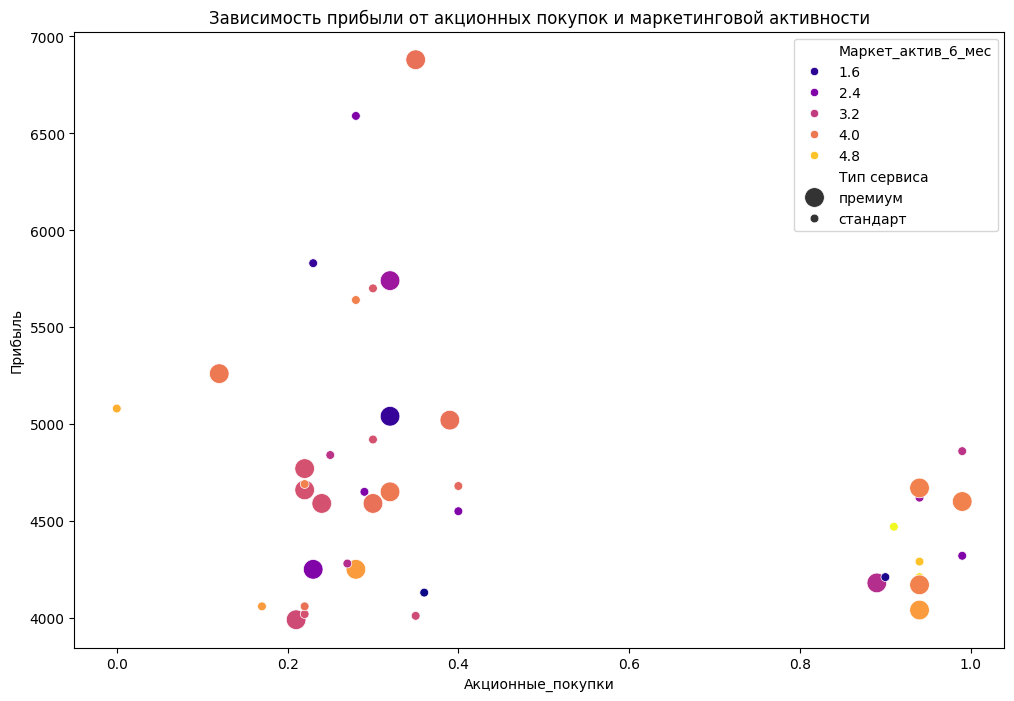

In [109]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=segment, 
    x='Акционные_покупки', 
    y='Прибыль', 
    hue='Маркет_актив_6_мес',  # Цвет точек в зависимости от 'Маркет_актив_6_мес'
    size='Тип сервиса',  # Размер точек в зависимости от 'Тип сервиса'
    sizes=(40, 200),  # Размеры точек, можно адаптировать
    palette='plasma',  # Палитра для цвета
)

# Добавление заголовка и меток осей
plt.title('Зависимость прибыли от акционных покупок и маркетинговой активности')
plt.xlabel('Акционные_покупки')
plt.ylabel('Прибыль')

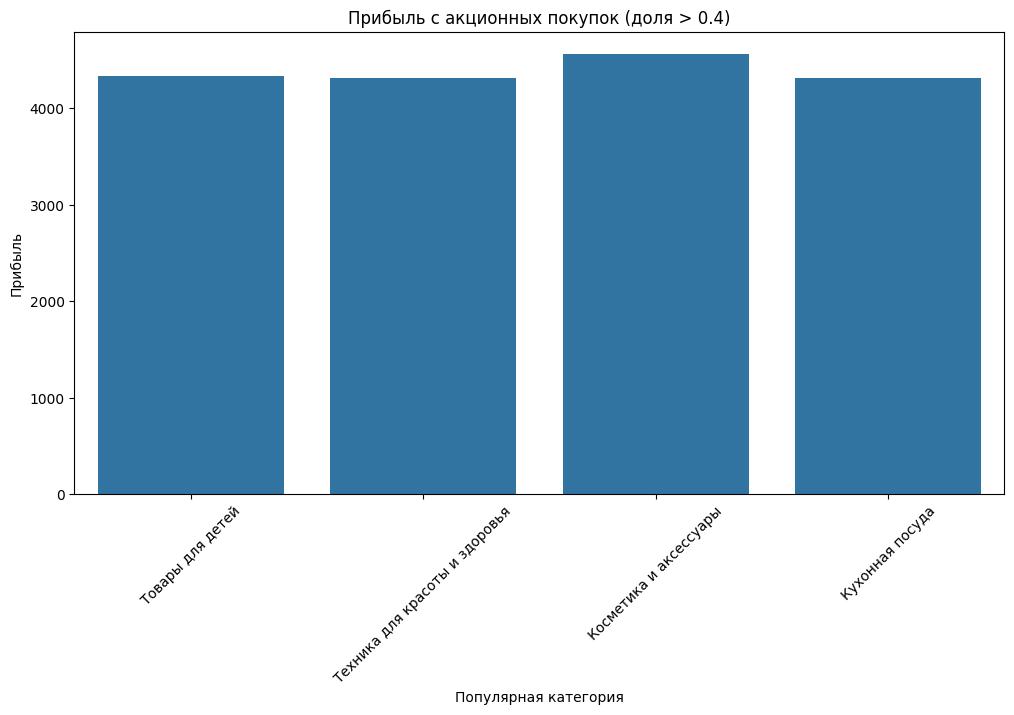

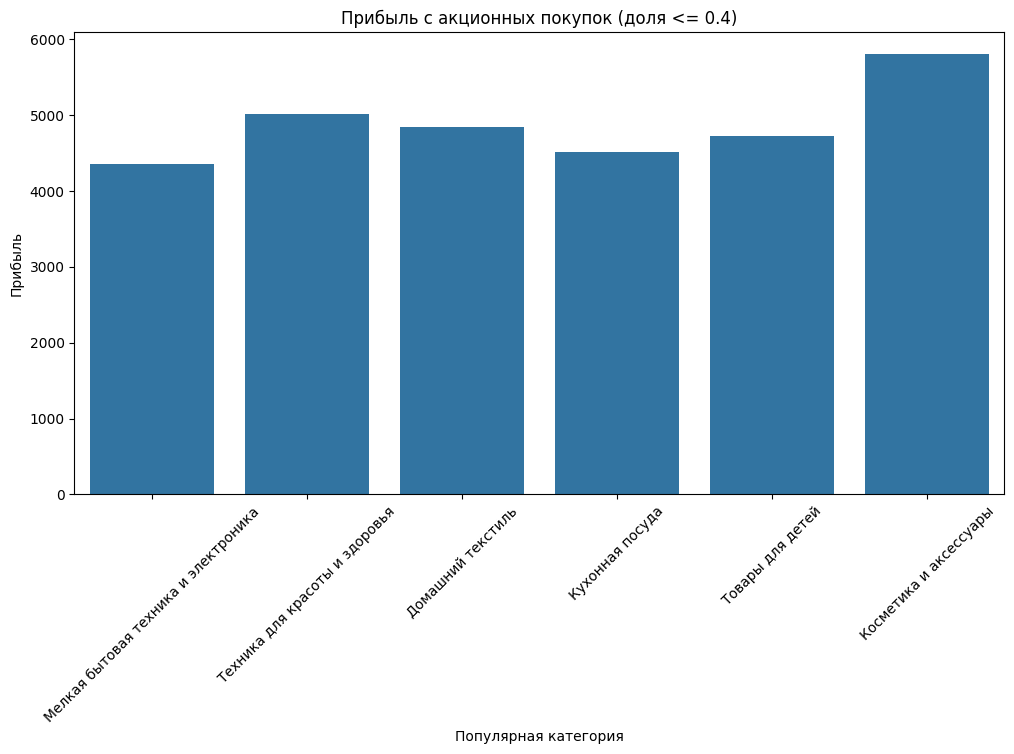

In [112]:
segment_high = segment[segment['Акционные_покупки'] > 0.4]
segment_low = segment[segment['Акционные_покупки'] <= 0.4]

# Построим барплот для акционных покупок с долей больше 0.4
plt.figure(figsize=(12, 6))
sns.barplot(x='Популярная_категория', y='Прибыль', data=segment_high, errorbar=None)
plt.title('Прибыль с акционных покупок (доля > 0.4)')
plt.xlabel('Популярная категория')
plt.ylabel('Прибыль')
plt.xticks(rotation=45)
plt.show()

# Построим барплот для акционных покупок с долей меньше или равной 0.4
plt.figure(figsize=(12, 6))
sns.barplot(x='Популярная_категория', y='Прибыль', data=segment_low, errorbar=None)
plt.title('Прибыль с акционных покупок (доля <= 0.4)')
plt.xlabel('Популярная категория')
plt.ylabel('Прибыль')
plt.xticks(rotation=45)
plt.show()

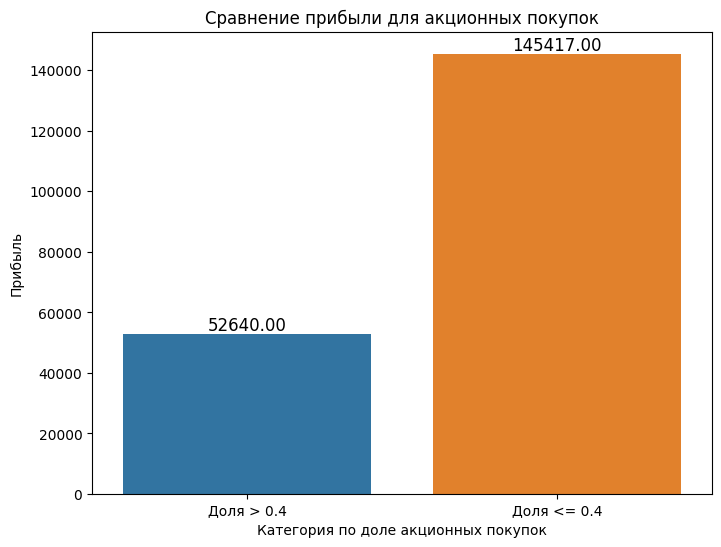

In [113]:


# Разделим данные на два поднабора
segment_high = segment[segment['Акционные_покупки'] > 0.4]
segment_low = segment[segment['Акционные_покупки'] <= 0.4]

# Считаем сумму прибыли для каждого поднабора
profit_high = segment_high['Прибыль'].sum()
profit_low = segment_low['Прибыль'].sum()

# Подготовим данные для визуализации
profits = [profit_high, profit_low]
labels = ['Доля > 0.4', 'Доля <= 0.4']

# Создаем bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=profits, hue=labels ,legend=False)

# Добавляем цифры на столбцы
for i, v in enumerate(profits):
    ax.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

# Добавим заголовок и метки осей
plt.title('Сравнение прибыли для акционных покупок')
plt.xlabel('Категория по доле акционных покупок')
plt.ylabel('Прибыль')

# Отображаем график
plt.show()


# Выводы и рекомендации для бизнеса

## Выводы:

1. **Распределение премиум и стандартных подписчиков**:
   Пропорция подписчиков с премиум и стандартными статусами почти одинакова. Это может указывать на необходимость пересмотра политики привилегий. Возможно, стоит усилить предложение для премиум-пользователей или добавить дополнительные привилегии для стандартных подписчиков, чтобы стимулировать их переход в премиум сегмент.  
   🎁 **Рекомендация**: Дать больше привилегий стандартным пользователям, чтобы повысить их лояльность.

2. **Использование акций**:
   Подписчики неохотно пользуются предложениями акций. Текущий уровень активации акций составляет лишь 25% (5 из 19). Это может свидетельствовать о недостаточной привлекательности предложений или их плохой видимости.  
   🎯 **Рекомендация**: Улучшить видимость акций и сделать их более персонализированными для разных пользователей.

3. **Прибыль по категориям товаров**:
   Наибольшую прибыль приносят товары из категорий: кухонная посуда, товары для детей, косметика и аксессуары. Также стоит отметить высокую прибыль в сегменте домашнего текстиля.  
   🛍️ **Рекомендация**: Уделить внимание продвижению этих категорий и расширению ассортимента.

4. **Зависимость между страницами за визит и прибылью**:
   Страниц за визит больше всего на 4, при этом прибыль распределяется практически равномерно среди всех пользователей.  
   📊 **Рекомендация**: Улучшить навигацию и предлагать больше персонализированных рекомендаций товаров.

5. **Активность пользователей с низким количеством страниц за визит**:
   Пользователи, которые посещают меньше страниц за визит, имеют высокие вероятности снижения своей активности.  
   🔄 **Рекомендация**: Применить targeted-контент, акции и персонализированные предложения для повышения вовлеченности.

6. **Акционные покупки и их влияние на прибыль**:
   Хотя доля пользователей с более чем 40% акционных покупок составляет лишь 25%, они приносят 43% всей прибыли.  
   💰 **Рекомендация**: Сконцентрироваться на увеличении доли таких пользователей через улучшение маркетинговых стратегий и персонализацию предложений.

7. **Корреляция акционных покупок и покупательской активности**:
   Корреляция между акционными покупками и покупательской активностью умеренная (0.5).  
   🔍 **Рекомендация**: Повысить целенаправленность акций и предложений для повышения покупательской активности.

8. **Влияние времени на сайте на покупательскую активность**:
   Наиболее сильная корреляция (0.68) между временем, проведенным пользователями на сайте в текущем месяце, и их покупательской активностью.  
   ⏱️ **Рекомендация**: Оптимизировать сайт для увеличения времени, проведенного пользователями на платформе, и предлагать актуальный контент.

---

## Рекомендации для бизнеса:

1. **Пересмотрите привилегии для подписчиков**:
   Увеличьте количество и качество привилегий для подписчиков, особенно для тех, кто находится на стандартном уровне. Это поможет повысить их лояльность и мотивировать на переход в премиум.

2. **Увеличьте вовлеченность пользователей в акции**:
   Улучшите видимость акций, сделайте их более персонализированными и релевантными для разных сегментов пользователей. Это поможет повысить активность и интерес к акциям.

3. **Уделите внимание прибыльным категориям товаров**:
   Сосредоточьте усилия на развитии и продвижении товаров, которые приносят наибольшую прибыль. Рассмотрите возможность расширения ассортимента в этих категориях.

4. **Оптимизируйте пользовательский опыт на сайте**:
   Повышение количества страниц за визит не всегда напрямую связано с покупками. Улучшите навигацию, предложите пользователям релевантный контент и рекомендации товаров для повышения вовлеченности.

5. **Развивайте сегмент акционных покупателей**:
   Разработайте стратегии для увеличения доли пользователей, активно участвующих в акциях, с помощью targeted marketing и лояльностных программ.

6. **Оптимизируйте время на сайте**:
   Увеличьте время пребывания пользователей на сайте, улучшив пользовательский интерфейс и предлагая персонализированные предложения и контент.

---

🚀 **Потенциальные действия для улучшения бизнеса**:  
1. Повысить лояльность и активность пользователей через персонализированные предложения и акции.  
2. Улучшить предложение в прибыльных категориях товаров для стимулирования покупок.  
3. Оптимизировать взаимодействие с пользователями через сайт для увеличения времени пребывания и повышения покупательской активности.  
4. Сконцентрировать усилия на увеличении числа пользователей, которые активно используют акции, чтобы повысить общую прибыль.



## 9. Итоговый вывод

### Описание задачи

🎯 **Целью данной работы** было построение модели для бинарной классификации покупательской активности на основе данных о посещении сайта. Задача заключалась в выявлении значимых факторов, влияющих на поведение пользователей, с целью улучшения маркетинговых стратегий и предложений для различных сегментов покупателей.

🔍 **Исходные данные** были проверены на пропуски, аномальные и пропущенные значения, опечатки устранены.

💡 Для поиска лучшей модели был создан **пайплайн** с применением нескольких алгоритмов машинного обучения:

- Логистическая регрессия
- Метод ближайших соседей (KNN)
- Дерево решений
- Метод опорных векторов (SVC)

🔧 Для оптимизации моделей использовался **рандомизированный поиск гиперпараметров** (Randomized Search Cross-Validation), позволяющий эффективно найти лучшие гиперпараметры. Оценка производилась по метрике **ROC-AUC**, что позволило выбрать наиболее стабильную и точную модель.

🏆 **Лучшая модель**, продемонстрировавшая наибольшую точность предсказаний, оказалась **SVC** с оптимизированными гиперпараметрами.
